# XGBoost

This notebook will be used to tune and evaluate the XGBoost model.

We will tune the model hyperparameters using crossvalidation and considering two different scores: balanced_accuracy and f1_weighted.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.model_datatransforms import *

---
# Data Loading

In [2]:
df = pd.read_parquet('data/pred_model_data_full.parquet')

In [3]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

Since we have fewer observations for 'Music non-amplified' and 'Nature elements - Wind', and that the level of certainty that these observations are being correctly classified is lower than for the other classes, we will join these classes to 'Unsupported' and call the new class 'Other'

In [3]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [4]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Compute class weight for each observation

In [6]:
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights

array([0.73027151, 0.32680671, 0.32680671, ..., 0.32680671, 0.32680671,
       0.32680671])

In [7]:
n_classes=len(df.noise_event_laeq_primary_detected_class.unique())
n_classes

5

---
# balanced_accuracy

In [23]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [24]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.4814382635251248

Hyperparameter tuning

In [25]:
#choose parameters
n_estimators = np.arange(100,600,100)
learning_rate = np.array([0.01,0.1,0.3, 0.5])
max_depth = np.arange(2,17,3)

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month','season'], 
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot', 'binary'], 
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth
}

In [26]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=50, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.6262439586095742
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.3, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

We include in the pipeline the best hyperparameters obtained

In [8]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes,  n_estimators=200, max_depth=2, learning_rate=0.3))
])

In [9]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                  

In [39]:
y_pred = pipeline.predict(X_test)

In [10]:
y_pred_proba = pipeline.predict_proba(X_test)

Obtain accuracy and balanced accuracy scores

In [41]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.6410012947777298
Balanced Accuracy: 0.6354658309743623


In [11]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.8700665821730954

Confusion matrix

In [34]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

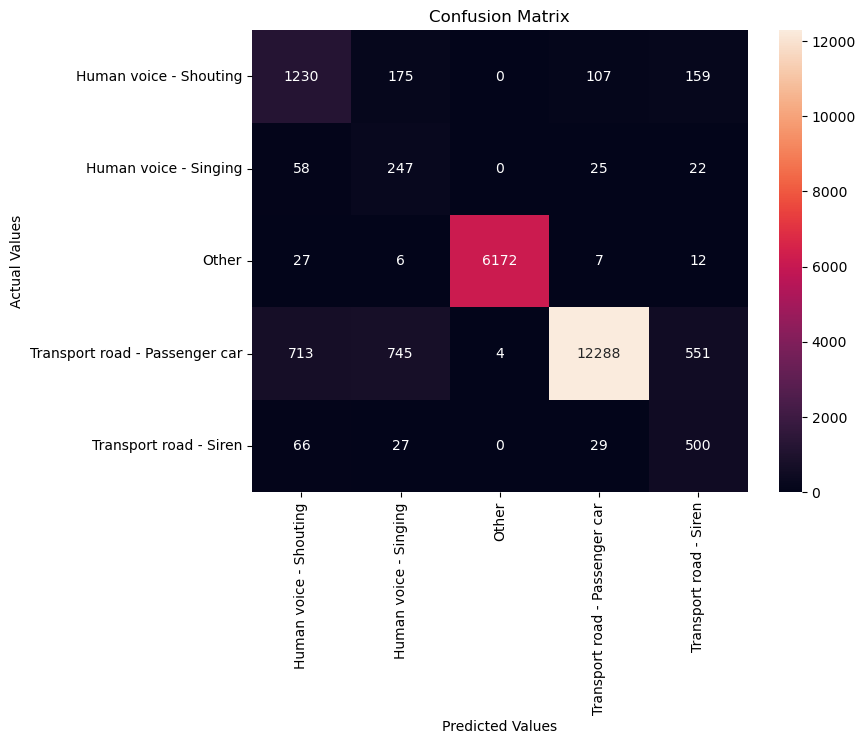

In [42]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Classification report

In [43]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.40      0.66      0.50      1671
         Human voice - Singing       0.10      0.66      0.18       352
                         Other       0.50      0.31      0.39      6224
Transport road - Passenger car       0.87      0.78      0.82     14301
        Transport road - Siren       0.31      0.78      0.44       622

                      accuracy                           0.64     23170
                     macro avg       0.44      0.64      0.46     23170
                  weighted avg       0.71      0.64      0.66     23170



---
# No certainty + f1_weighted

In [9]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [36]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7384575215739

Hyperparameter tuning

In [10]:
#choose parameters
n_estimators = np.arange(100,600,100)
learning_rate = np.array([0.01,0.1,0.3, 0.5])
max_depth = np.arange(2,12,2)

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month','season'], 
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot', 'binary'], 
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth
}

In [11]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=50, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.7441647811360146
Best Parameters: {'xgb__n_estimators': 300, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [12]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes,  n_estimators=300, max_depth=10, learning_rate=0.1))
])

In [13]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               m

In [14]:
y_pred = pipeline.predict(X_test)

In [14]:
y_pred_proba = pipeline.predict_proba(X_test)

Obtain accuracy and balanced accuracy scores

In [16]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.7507984462667242
Balanced Accuracy: 0.5646027868975404


In [15]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.906807300206572

Confusion matrix

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

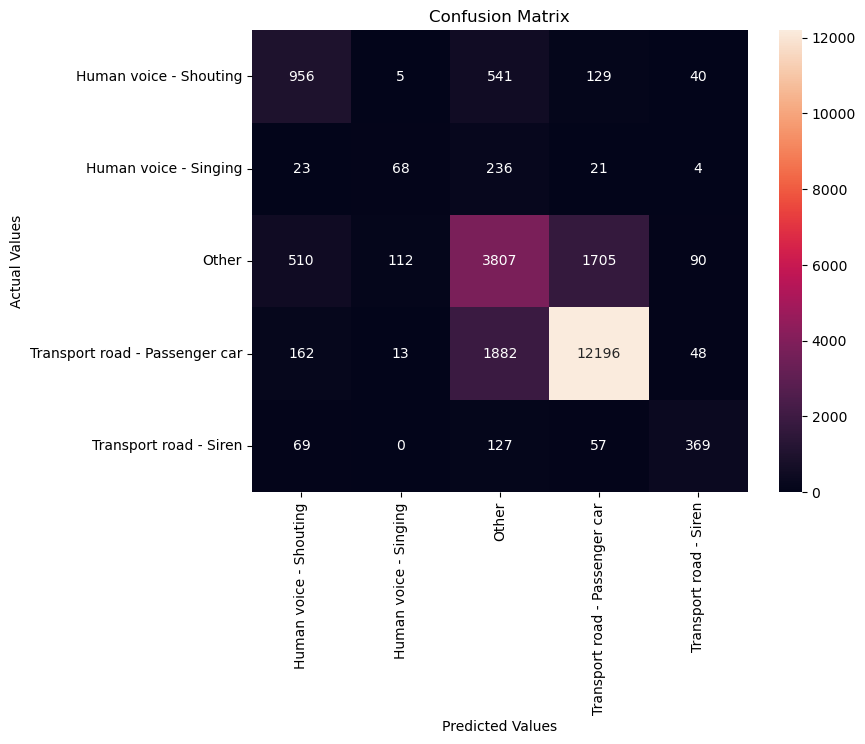

In [19]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Classification report

In [20]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.56      0.57      0.56      1671
         Human voice - Singing       0.34      0.19      0.25       352
                         Other       0.58      0.61      0.59      6224
Transport road - Passenger car       0.86      0.85      0.86     14301
        Transport road - Siren       0.67      0.59      0.63       622

                      accuracy                           0.75     23170
                     macro avg       0.60      0.56      0.58     23170
                  weighted avg       0.75      0.75      0.75     23170

